In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import pyvista as pv
import torch.nn as nn
import torch.optim as optim
import nibabel as nib
from scipy.ndimage import zoom
from torchvision.transforms import RandomRotation
import cv2

In [2]:
# paths
csv_file = '/Users/shivamgoyal/Desktop/DL/Project/archive/indiana_projections.csv'
image_folder = '/Users/shivamgoyal/Desktop/DL/Project/images_png'
csv_file = '/Users/shivamgoyal/Desktop/DL/Project/archive/indiana_projections.csv'
data = pd.read_csv(csv_file)

data['filename'] = data['filename'].apply(lambda x: f"CXR{x}.png" if not x.startswith("CXR") else x)

# Save the modified CSV
modified_csv_file = '/Users/shivamgoyal/Desktop/DL/Project/modified_indiana_projections.csv'
data.to_csv(modified_csv_file, index=False)
print(f"Modified CSV saved to: {modified_csv_file}")

Modified CSV saved to: /Users/shivamgoyal/Desktop/DL/Project/modified_indiana_projections.csv


Starting Epoch 1/1
Epoch 1, Batch 1, Generator Loss: 1.2075318098068237, Discriminator Loss: 0.6912612915039062, SNR: 0.42, SSIM: 0.02
Epoch 1, Batch 2, Generator Loss: 1.0039350986480713, Discriminator Loss: 0.66810542345047, SNR: 2.13, SSIM: 0.03
Epoch 1, Batch 3, Generator Loss: 0.9905343055725098, Discriminator Loss: 0.5656009316444397, SNR: 2.35, SSIM: 0.02
Epoch 1, Batch 4, Generator Loss: 1.0329689979553223, Discriminator Loss: 0.5300067067146301, SNR: 2.70, SSIM: 0.03
Epoch 1, Batch 5, Generator Loss: 1.281488060951233, Discriminator Loss: 0.5003547668457031, SNR: 3.13, SSIM: 0.04
Epoch 1, Batch 6, Generator Loss: 1.1453884840011597, Discriminator Loss: 0.5177791118621826, SNR: 2.96, SSIM: 0.06
Epoch 1, Batch 7, Generator Loss: 1.1542129516601562, Discriminator Loss: 0.4646983742713928, SNR: 2.57, SSIM: 0.04
Epoch 1, Batch 8, Generator Loss: 1.337240219116211, Discriminator Loss: 0.4091854393482208, SNR: 2.17, SSIM: 0.05
Epoch 1, Batch 9, Generator Loss: 1.5452429056167603, Dis

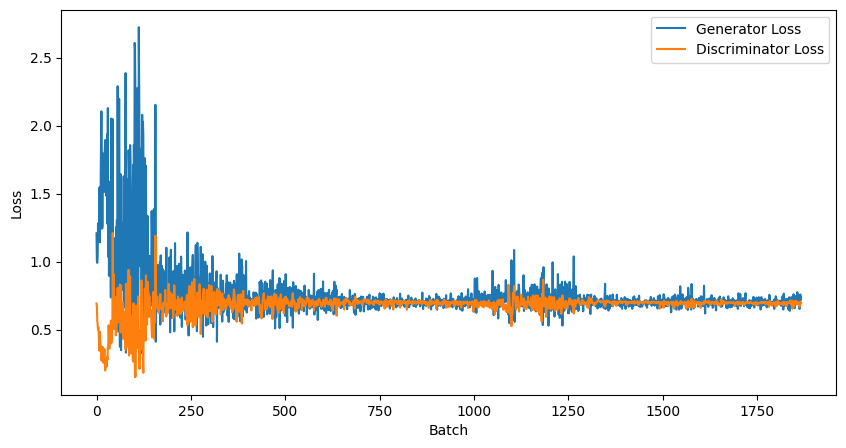

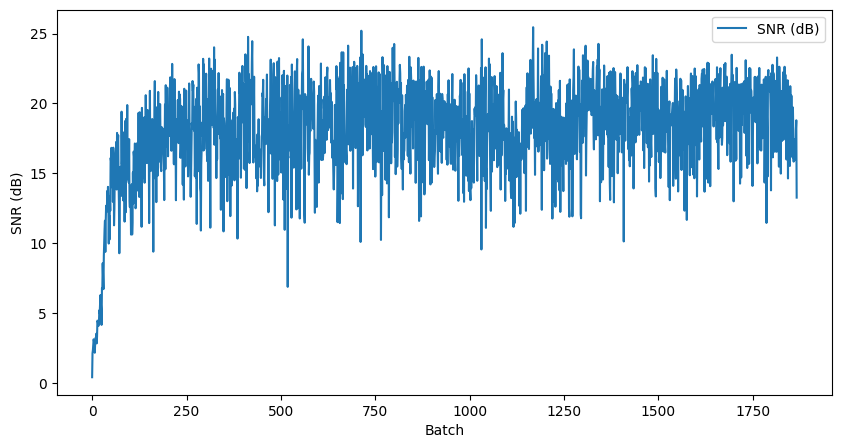

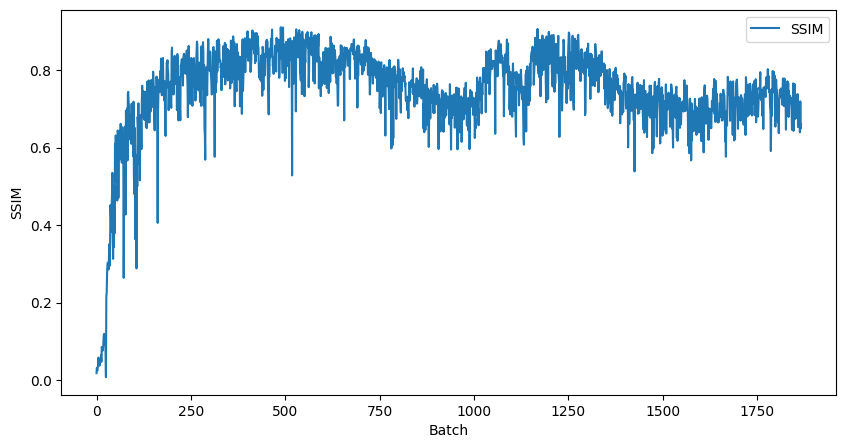

Final SNR: 18.12 dB
Final SSIM: 0.75


In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


# X-Ray Dataset
class XRayDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        uid = row['uid']

        # Paths for frontal and lateral images
        frontal_path = os.path.join(self.image_folder, row['filename'])
        lateral_path = os.path.join(self.image_folder, row['filename'].replace('Frontal', 'Lateral'))

        # Open images
        frontal_image = Image.open(frontal_path).convert("L")  # Grayscale
        lateral_image = Image.open(lateral_path).convert("L")  # Grayscale

        # Apply transformations
        if self.transform:
            frontal_image = self.transform(frontal_image)
            lateral_image = self.transform(lateral_image)

        return frontal_image, lateral_image, uid


# Generator (U-Net)
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetGenerator, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=False),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=False)
            )

        # Separate Encoders for Frontal and Lateral Features
        self.frontal_encoder = conv_block(in_channels, 64)
        self.lateral_encoder = conv_block(in_channels, 64)

        # Shared Encoder
        self.shared_encoder2 = conv_block(128, 128)  # Takes combined output from frontal + lateral
        self.shared_encoder3 = conv_block(128, 256)
        self.shared_encoder4 = conv_block(256, 512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)  # Takes bottleneck output + shared_encoder4 skip

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        # Final output layer
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, frontal, lateral):
        # Encode Frontal and Lateral Features
        frontal_enc1 = self.frontal_encoder(frontal)  # Shape: [batch_size, 64, H, W]
        lateral_enc1 = self.lateral_encoder(lateral)  # Shape: [batch_size, 64, H, W]
    
        # Combine Features
        combined_enc1 = torch.cat((frontal_enc1, lateral_enc1), dim=1)  # Shape: [batch_size, 128, H, W]
    
        # Shared Encoding
        enc2 = self.shared_encoder2(nn.MaxPool2d(2)(combined_enc1))  # Shape: [batch_size, 128, H/2, W/2]
        enc3 = self.shared_encoder3(nn.MaxPool2d(2)(enc2))  # Shape: [batch_size, 256, H/4, W/4]
        enc4 = self.shared_encoder4(nn.MaxPool2d(2)(enc3))  # Shape: [batch_size, 512, H/8, W/8]
    
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))  # Shape: [batch_size, 1024, H/16, W/16]
    
        # Decoding with Skip Connections
        dec4 = self.upconv4(bottleneck)  # Shape: [batch_size, 512, H/8, W/8]
        dec4 = torch.cat((dec4, enc4), dim=1)  # Shape: [batch_size, 1024, H/8, W/8]
        dec4 = self.decoder4(dec4)  # Shape: [batch_size, 512, H/8, W/8]
    
        dec3 = self.upconv3(dec4)  # Shape: [batch_size, 256, H/4, W/4]
        dec3 = torch.cat((dec3, enc3), dim=1)  # Shape: [batch_size, 512, H/4, W/4]
        dec3 = self.decoder3(dec3)  # Shape: [batch_size, 256, H/4, W/4]
    
        dec2 = self.upconv2(dec3)  # Shape: [batch_size, 128, H/2, W/2]
        dec2 = torch.cat((dec2, enc2), dim=1)  # Shape: [batch_size, 256, H/2, W/2]
        dec2 = self.decoder2(dec2)  # Shape: [batch_size, 128, H/2, W/2]
    
        dec1 = self.upconv1(dec2)  # Shape: [batch_size, 64, H, W]
        dec1 = torch.cat((dec1, frontal_enc1), dim=1)  # Shape: [batch_size, 128, H, W]
        dec1 = self.decoder1(dec1)  # Shape: [batch_size, 64, H, W]
    
        # Final output
        output = self.output_layer(dec1)  # Shape: [batch_size, out_channels, H, W]
        return output


# PatchGAN Discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=False),  # Avoid in-place operation
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)


# Loss Functions
adversarial_loss = nn.BCEWithLogitsLoss()
reconstruction_loss = nn.MSELoss()

# Initialize Models
generator = UNetGenerator(in_channels=6, out_channels=1)
discriminator = PatchGANDiscriminator(in_channels=1)

# Optimizers
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to calculate SNR
def calculate_snr(signal, noise):
    signal = signal.astype(np.float32)
    noise = noise.astype(np.float32)
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    if noise_power == 0:
        return float("inf")
    elif signal_power == 0:
        return -float("inf")
    snr = 10 * np.log10(signal_power / noise_power)
    return snr


# Training Function
def train_gan_with_lateral(generator, discriminator, dataloader, num_epochs=1, device='cpu'):
    gen_losses = []
    disc_losses = []
    snr_values = []
    ssim_values = []

    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch + 1}/{num_epochs}")
        for batch_idx, batch in enumerate(dataloader):
            try:
                # Load batch data
                frontal, lateral, uid = batch
                frontal, lateral = frontal.to(device), lateral.to(device)

                # Train Generator
                gen_optimizer.zero_grad()
                fake_images = generator(frontal, lateral)
                disc_output_fake = discriminator(fake_images)

                # Generator loss
                real_labels = torch.ones_like(disc_output_fake, device=device)
                g_loss = adversarial_loss(disc_output_fake, real_labels) + \
                         reconstruction_loss(fake_images, frontal) + \
                         reconstruction_loss(fake_images, lateral)
                g_loss.backward()
                gen_optimizer.step()

                # Train Discriminator
                disc_optimizer.zero_grad()
                disc_output_real = discriminator(frontal)
                disc_output_fake = discriminator(fake_images.detach())

                # Discriminator loss
                fake_labels = torch.zeros_like(disc_output_fake, device=device)
                d_loss_real = adversarial_loss(disc_output_real, real_labels)
                d_loss_fake = adversarial_loss(disc_output_fake, fake_labels)
                d_loss = (d_loss_real + d_loss_fake) / 2
                d_loss.backward()
                disc_optimizer.step()

                # Track losses
                gen_losses.append(g_loss.item())
                disc_losses.append(d_loss.item())

                # Calculate SNR and SSIM
                fake_images_np = fake_images.detach().cpu().numpy()
                frontal_np = frontal.detach().cpu().numpy()
                noise = frontal_np - fake_images_np
                snr = calculate_snr(frontal_np, noise)
                snr_values.append(snr)

                ssim_batch = [
                    ssim(frontal_np[i, 0], fake_images_np[i, 0], data_range=1.0)
                    for i in range(fake_images_np.shape[0])
                ]
                avg_ssim = np.mean(ssim_batch)
                ssim_values.append(avg_ssim)

                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Generator Loss: {g_loss.item()}, "
                      f"Discriminator Loss: {d_loss.item()}, SNR: {snr:.2f}, SSIM: {avg_ssim:.2f}")
            except Exception as e:
                print(f"Error: {e}")
                continue

    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot SNR and SSIM
    plt.figure(figsize=(10, 5))
    plt.plot(snr_values, label="SNR (dB)")
    plt.xlabel("Batch")
    plt.ylabel("SNR (dB)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(ssim_values, label="SSIM")
    plt.xlabel("Batch")
    plt.ylabel("SSIM")
    plt.legend()
    plt.show()

    # Print Final Metrics
    print(f"Final SNR: {np.mean(snr_values):.2f} dB")
    print(f"Final SSIM: {np.mean(ssim_values):.2f}")

# Main
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    dataset = XRayDataset(
        csv_file='/Users/shivamgoyal/Desktop/DL/Project/indiana_projections_fixed.csv',
        image_folder='/Users/shivamgoyal/Desktop/DL/Project/images_png',
        transform=transform
    )
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Initialize Updated Models
    generator = UNetGenerator(in_channels=1, out_channels=1).to('cpu')
    discriminator = PatchGANDiscriminator(in_channels=1).to('cpu')

    # Define Optimizers
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    # Train the GAN
    train_gan_with_lateral(generator, discriminator, dataloader, num_epochs=1, device='cpu')

In [5]:
# Save the trained model
torch.save(generator.state_dict(), "/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/generator.pth")
torch.save(discriminator.state_dict(), "/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/discriminator.pth")

# Save the optimizers if you need to resume training
torch.save(gen_optimizer.state_dict(), "/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/gen_optimizer.pth")
torch.save(disc_optimizer.state_dict(), "/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/disc_optimizer.pth")

print("Models and optimizers saved successfully.")

Models and optimizers saved successfully.


In [6]:
# Initialize models and optimizers
generator = UNetGenerator(in_channels=1, out_channels=1)  # Match saved model architecture
discriminator = PatchGANDiscriminator(in_channels=1)

# Load the trained weights
# Load weights only
generator.load_state_dict(torch.load("/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/generator.pth", weights_only=True))
discriminator.load_state_dict(torch.load("/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/discriminator.pth", weights_only=True))
# If you want to resume training, load the optimizers
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

gen_optimizer.load_state_dict(torch.load("/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/gen_optimizer.pth", weights_only=True))
disc_optimizer.load_state_dict(torch.load("/Users/shivamgoyal/Desktop/DL/Project/3D_Gan/disc_optimizer.pth", weights_only=True))

print("Models and optimizers loaded successfully.")

Models and optimizers loaded successfully.


In [7]:
import numpy as np
import torch

def generate_3d_image(uids, dataloader, generator, output_dir="output"):
    """
    Generate 3D images for specific UIDs.

    Args:
        uids (list): List of target UIDs.
        dataloader (DataLoader): DataLoader object.
        generator (nn.Module): Trained generator model.
        output_dir (str): Directory to save the output files.
    """
    print("\nGenerating 3D images...")
    device = torch.device("cpu")
    generator.to(device)
    generator.eval()  # Set the generator to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            try:
                frontal, lateral, uid = batch
                frontal, lateral = frontal.to(device), lateral.to(device)

                # Loop through the batch and process only the target UIDs
                for i in range(len(uid)):
                    if int(uid[i]) in uids:  # Check if the UID is in the target list
                        # Generate image for this UID
                        fake_image = generator(frontal[i].unsqueeze(0), lateral[i].unsqueeze(0))
                        fake_image = fake_image.squeeze(0).detach().cpu().numpy()  # Convert to numpy array

                        # Stack the 2D images into a 3D array
                        fake_3d_image = np.stack([fake_image] * 64, axis=0)  # Example: stack 64 layers
                        print(f"UID: {uid[i]} - 3D image shape: {fake_3d_image.shape}")

                        # Save the 3D image as a NumPy file
                        os.makedirs(output_dir, exist_ok=True)
                        np.save(f"{output_dir}/3d_output_UID_{uid[i]}.npy", fake_3d_image)
                        print(f"3D image for UID {uid[i]} saved as {output_dir}/3d_output_UID_{uid[i]}.npy")

            except Exception as e:
                print(f"Error generating 3D image for batch {batch_idx + 1}: {e}")
                continue

In [8]:
generate_3d_image([1, 2, 3], dataloader, generator)


Generating 3D images...
UID: 2 - 3D image shape: (64, 1, 128, 128)
3D image for UID 2 saved as output/3d_output_UID_2.npy
UID: 1 - 3D image shape: (64, 1, 128, 128)
3D image for UID 1 saved as output/3d_output_UID_1.npy
UID: 3 - 3D image shape: (64, 1, 128, 128)
3D image for UID 3 saved as output/3d_output_UID_3.npy


KeyboardInterrupt: 

Loaded 3D image with shape: (64, 1, 128, 128)
Squeezed 3D image shape: (64, 128, 128)
Max along X (depth): 63, Min: 0
Max along Y (height): 127, Min: 0
Max along Z (width): 127, Min: 0
Number of voxels above threshold: 892608


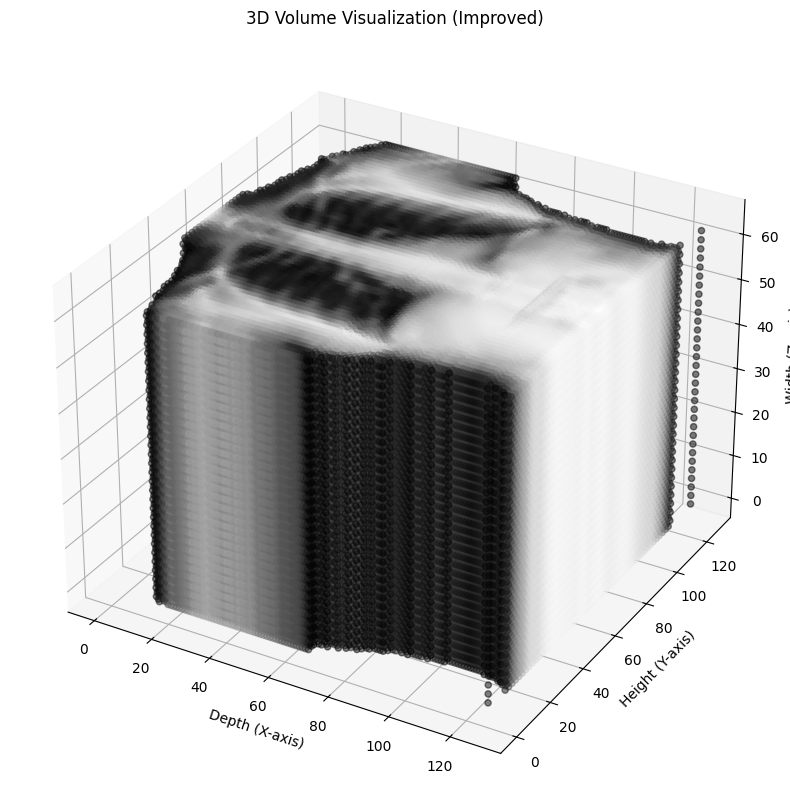

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def interactive_3d_plot_improved(file_path):
    # Load the 3D image
    volume = np.load(file_path)
    print(f"Loaded 3D image with shape: {volume.shape}")

    # Check if it's a 3D array with a single channel
    if len(volume.shape) == 4 and volume.shape[1] == 1:  # If there's a single channel
        volume = volume.squeeze(1)  # Remove the channel dimension
        print(f"Squeezed 3D image shape: {volume.shape}")

    # Normalize the volume intensities to [0, 1] for better visualization
    volume = (volume - volume.min()) / (volume.max() - volume.min())

    # Apply a threshold to select meaningful voxels
    threshold = 0.2  # Adjust threshold if needed
    x, y, z = np.where(volume > threshold)

    print(f"Max along X (depth): {x.max()}, Min: {x.min()}")
    print(f"Max along Y (height): {y.max()}, Min: {y.min()}")
    print(f"Max along Z (width): {z.max()}, Min: {z.min()}")
    print(f"Number of voxels above threshold: {len(x)}")

    # Downsample the data (optional, adjust step size as needed)
    step = 2  # Adjust step size for downsampling
    x, y, z = x[::step], y[::step], z[::step]

    # Create a 3D figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the selected voxels
    ax.scatter(y, z, x, c=volume[x, y, z], cmap='gray', marker='o', alpha=0.5)

    # Set labels and show the plot
    ax.set_xlabel("Depth (X-axis)")
    ax.set_ylabel("Height (Y-axis)")
    ax.set_zlabel("Width (Z-axis)")
    ax.set_title("3D Volume Visualization (Improved)")
    plt.show()

# Example: View the file for UID 2
interactive_3d_plot_improved("3d_output_UID_3.npy")